<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/VDSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Very Deep Super-Resolution avec le Deep Learning

Nous allons voir comment entrainer un réseau de neurones "Very-Deep Super-Resolution" (VDSR) et utiliser le réseau afin d'obtenir une image haute résolution à partir d'une image en basse résolution. 


![Présentation](https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/illustration_2.png?raw=true) 
  
Plusieurs techniques permettent de produire une image haute résolution à partir d'une image basse résolution, dont les techniques à base d'apprentissage profond. Nous allons ici utiliser [l'algorithme VDSR](https://arxiv.org/abs/1511.04587)

In [2]:
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import schedules
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras.models import model_from_json
from tensorflow.image import extract_patches

import sklearn.feature_extraction as feature_extract
from sklearn.model_selection import train_test_split


from PIL import Image, ImageOps


# Téléchargement et chargement des données

Le nombre de données est très grand, le fichier contient 20 000 images et sa taille est d'environ 1,6 Go

In [2]:
!wget "http://www-i6.informatik.rwth-aachen.de/imageclef/resources/iaprtc12.tgz"
!tar xzf iaprtc12.tgz

--2021-02-22 11:43:10--  http://www-i6.informatik.rwth-aachen.de/imageclef/resources/iaprtc12.tgz
Resolving www-i6.informatik.rwth-aachen.de (www-i6.informatik.rwth-aachen.de)... 137.226.36.140
Connecting to www-i6.informatik.rwth-aachen.de (www-i6.informatik.rwth-aachen.de)|137.226.36.140|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1764963259 (1.6G) [application/x-tar]
Saving to: ‘iaprtc12.tgz’

iaprtc12.tgz        100%[===================>]   1.64G  17.8MB/s    in 95s     

2021-02-22 11:44:46 (17.7 MB/s) - ‘iaprtc12.tgz’ saved [1764963259/1764963259]



In [ ]:
!ls iaprtc12/images/ -l

Affichage d'une image aléatoire contenue dans le répertoire /images/39/ :

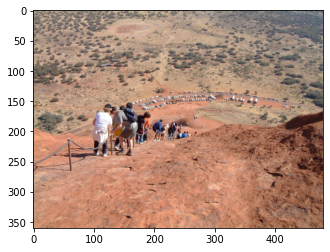

In [3]:
fichier = "iaprtc12/images/39/39"+str(int((random.randrange(0,1000))))+".jpg"
img=mpimg.imread(fichier)
plt.imshow(img)

In [ ]:
img

Chargement des images contenues dans le répertoire /images/39/

In [4]:
def ChargementImages(repertoire):
  images = []
  fichiers = sorted(glob.glob(repertoire+"*.jpg"))
  for fichier in fichiers:
    img = mpimg.imread(fichier)
    images.append(img)
  return np.array(images, dtype=object)

In [5]:
images = ChargementImages("iaprtc12/images/39/")

In [9]:
images.shape

(916,)

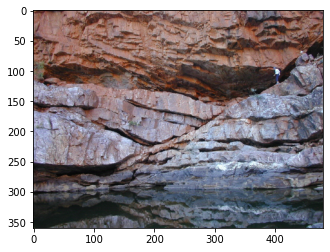

In [11]:
plt.imshow(images[0])

# Préparation des données d'entrainement

Chaque échantillon d'entrainement doit contenir :
 - X : Le canal de luminance de l'image basse résolution traitée par interpolation bicubique : Ybr
 - Y : L'image résiduelle : Yresiduelle = Yhr - Ybr (différence entre la luminance de l'image originale haute résolution et la luminance de l'image haute résolution reconstituée par interpolation bicubique à partir de l'image basse résolution)  

Les étapes sont les suivantes :  
- Convertir les images RGB au format YCbCr
- Normaliser les valeurs des pixels en un nombre à virgule flottante sur 64 bits compris entre 0.0 et 1.0
- Appliquer un facteur d'échelle aléatoire afin de créer une image basse résolution et extraire la partie luminance de l'image basse résolution
- Reconvertir cette image en haute résolution à l'aide de l'interpolation bicubique puis en extraire la luminance. **Ces données seront les échantillons X.**
- Extraire la luminance résiduelle (différence entre la luminance de l'image originale et la luminance de l'image reconstituée en haute résolution par interpolation bicubique). **Ces données seront les échantillons Y.**

**1. Conversion des images RGB au format YCrCb**  
Le [modèle **YCbCr**](https://fr.wikipedia.org/wiki/YCbCr) est une manière de représenter l'espace colorimétrique en vidéo, issue essentiellement des problèmes de transmission hertzienne. Ce standard a été développé à une époque où il fallait assurer la compatibilité des récépteurs de télévision noir et blanc et des récepteurs couleur.  

La couleur étant créée par la juxtaposition de trois types de luminophores rouge (R), vert (anglais : green, G) et bleu (B), il faut transmettre trois composantes, trois signaux. Cependant, le noir et blanc ne comprend qu'une seule teinte, le niveau de gris.  

Les trois signaux transmis ne sont donc pas les trois composantes RGB mais la teinte de gris Y, et la différence entre cette teinte et deux autres composantes.

Les trois informations sont donc la luminance (teinte de gris) et les deux chrominances. Le récepteur noir et blanc ne traitera que la luminance et les récepteurs en couleur déduiront les trois composantes RVB à partir de la luminance et des deux chrominances :  
- La luminance Y : Y = R + G + B (teinte de gris)
- La chrominance Cb : Y - B
- La chrominance Cr : Y - R  

Dans la pratique, les luminophores n'ont pas le même rendement, on applique donc des coefficients correcteurs.

Pour calculer les valeurs des composantes YCbCr d'une image à partir des composantes RVB (qui varient de 0 à 255), on utilise les formules suivantes :  

$\left\{ \begin{array}{l}
Y = 0,299R + 0,587V + 0,114B\\
{C_b} =  - 0,1687R - 0,3313V + 0,5B + 128\\
{C_r} = 0,5R - 0,4187V - 0,0813B + 128
\end{array} \right.$

In [6]:
def rgb2ycbcr(img):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = img.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [7]:
images_YCbCr = []

for img in images:
  images_YCbCr.append(rgb2ycbcr(img))

images_YCbCr = np.array(images_YCbCr,dtype=object)

In [ ]:
images_YCbCr[0]

**2. Application d'un facteur d'échelle aléatoire pour créer la luminance basse résolution**  
Pour créer l'image basse résolution, nous allons simplement utiliser la fonction resize du [module Image de la librairie Pillow](https://pillow.readthedocs.io/en/stable/reference/Image.html?highlight=resize%20image#module-PIL.Image), avec des échelles aléatoires et une interpolation de type bicubique.

In [8]:
Facteurs = [2,3,4]

images_Y_br = []

for img in images_YCbCr:
  FacteurEchelle = random.randrange(min(Facteurs),max(Facteurs)+1)
  img_PIL = Image.fromarray(img)
  img_PIL = img_PIL.resize(((round(img_PIL.size[0]*(1/FacteurEchelle)), round(img_PIL.size[1]*(1/FacteurEchelle)))),Image.BICUBIC)
  images_Y_br.append(np.array(img_PIL)[:,:,0])

images_Y_br = np.array(images_Y_br,dtype=object)

In [ ]:
images_Y_br[0]

Text(0.5, 1.0, 'Luminance (Echelle 1/2)')

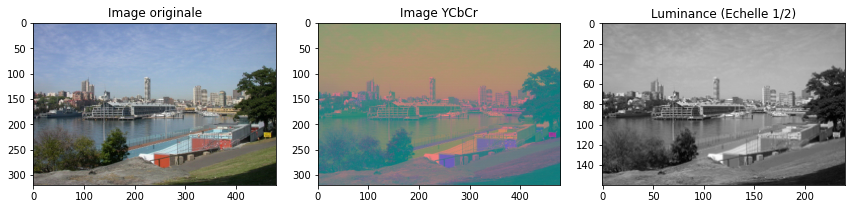

In [20]:
index = random.randrange(0,len(images)+1)

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(12,12))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(images[index])
ax[0].set_title("Image originale")

ax[1].imshow(images_YCbCr[index])
ax[1].set_title("Image YCbCr")

ax[2].imshow(np.array(images_Y_br[index],dtype='uint8'),cmap='gray')
ax[2].set_title("Luminance (Echelle 1/%d)" %(images[index].shape[0]/images_Y_br[index].shape[0]))


**3. Reconversion de la luminance en haute résolution à l'aide de l'interpolation bicubique**  
L'agrandissement des images se fait par interpolation. Il existe différentes méthodes : interpolation par plus proche voisin, interpolation bilinéaire, [interpolation bicubique](https://fr.wikipedia.org/wiki/Interpolation_bicubique).  

Dans le domaine du traitement d'images numériques, l'interpolation bicubique est souvent préférée à une interpolation bilinéaire ou à la technique du plus proche voisin pour le ré-échantillonnage d'images, lorsque le temps de traitement n'est pas critique. Contrairement à une interpolation bilinéaire, qui ne prend que 4 pixels (2 × 2) en compte, l'interpolation bicubique considère un voisinage de 16 pixels (4 × 4). Les images ré-échantillonnées par une interpolation bicubique sont donc plus lisses et ont moins d'artefacts d'interpolation. 

Commençons par créer les agrandissements avec l'interpolation bicubique des images en basse résolution :

In [9]:
images_Y_hr = []

for index in range(0,len(images_Y_br)):
  Echelle = images[index].shape[0] // images_Y_br[index].shape[0]
  img_PIL = Image.fromarray(images_Y_br[index])
  img_PIL = img_PIL.resize(((round(images_YCbCr[index].shape[1]), round(images_YCbCr[index].shape[0]))),Image.BICUBIC)
  images_Y_hr.append(np.array(img_PIL))

images_Y_hr = np.array(images_Y_hr,dtype=object)

Text(0.5, 1.0, 'Luminance HR (bicubique)')

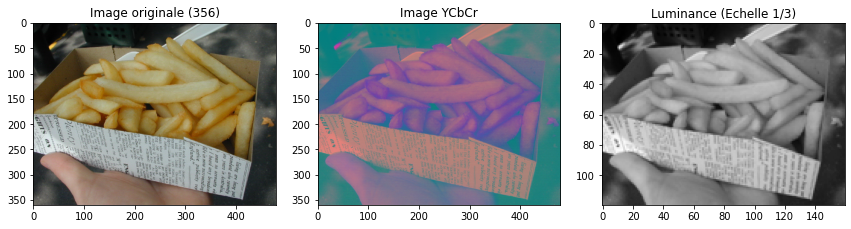

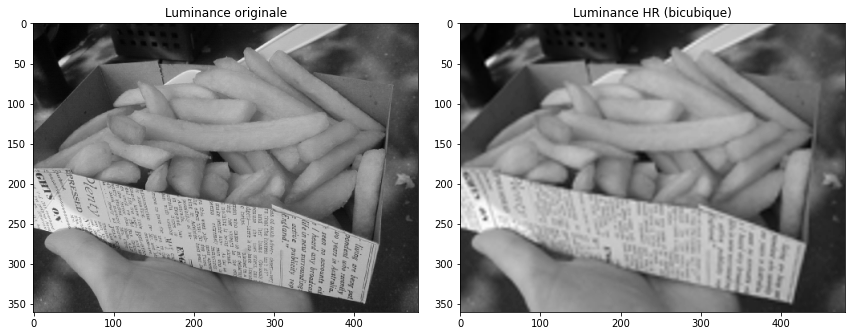

In [23]:
index = random.randrange(0,len(images)+1)

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(12,12))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(images[index])
ax[0].set_title("Image originale (%d)" %index)

ax[1].imshow(images_YCbCr[index])
ax[1].set_title("Image YCbCr")

ax[2].imshow(images_Y_br[index],cmap='gray')
ax[2].set_title("Luminance (Echelle 1/%d)" %(images[index].shape[0]/images_Y_br[index].shape[0]))

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,12))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(images_YCbCr[index][:,:,0],cmap='gray')
ax[0].set_title("Luminance originale")

ax[1].imshow(np.array(images_Y_hr[index],dtype='uint8'),cmap='gray')
ax[1].set_title("Luminance HR (bicubique)")


**4. Extraction des luminances résiduelles**  
Maintenant, sauvegardons les images résiduelles. La construction se fait en simplement en soustrayant les valeurs numériques des pixels de l'image au format YCbCr avec ceux de la luminance.  
Avant d'effectuer le calcul, on normalise les images au type `double` (valeurs flottantes 64 bits) entre [0,1] pour pouvoir gérer les valeurs négatives.

In [10]:
images_residuelles_Y = []

for index in range(0,len(images)):
  images_residuelles_Y.append((images_YCbCr[index][:,:,0].astype('double')/255.0 - images_Y_hr[index].astype('double')/255.0))
images_residuelles_Y = np.array(images_residuelles_Y,dtype=object)

In [38]:
images_residuelles_Y[0]

array([[-0.01176471,  0.00784314,  0.04705882, ...,  0.02352941,
        -0.01960784, -0.07058824],
       [ 0.00784314,  0.01568627,  0.02745098, ...,  0.03529412,
         0.01960784, -0.03921569],
       [ 0.03137255,  0.03529412,  0.02352941, ...,  0.0745098 ,
         0.0627451 ,  0.02745098],
       ...,
       [-0.03921569, -0.04313725, -0.02745098, ...,  0.01568627,
        -0.01176471, -0.01960784],
       [ 0.03921569,  0.03921569, -0.00784314, ...,  0.07058824,
        -0.01960784, -0.08235294],
       [ 0.08235294,  0.08235294,  0.01960784, ...,  0.08627451,
        -0.00784314, -0.08627451]])

Pour afficher les images résiduelles, on il faut retransformer les pixels en valeurs comprises entre 0 et 255 en prenant garde de ne pas garder les valeurds négatives :

In [54]:
np.asarray(images_residuelles_Y[0].clip(0,255)*255.0,dtype='uint8')

array([[ 0,  1, 11, ...,  5,  0,  0],
       [ 1,  4,  6, ...,  8,  5,  0],
       [ 8,  9,  5, ..., 18, 16,  7],
       ...,
       [ 0,  0,  0, ...,  4,  0,  0],
       [10, 10,  0, ..., 17,  0,  0],
       [21, 20,  5, ..., 22,  0,  0]], dtype=uint8)

Text(0.5, 1.0, 'Image résiduelle Y')

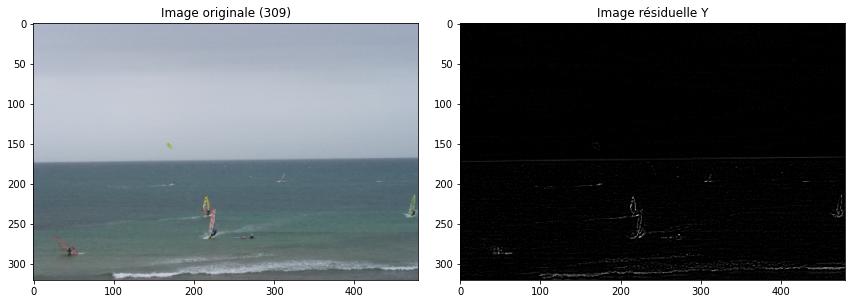

In [57]:
index = random.randrange(0,len(images)+1)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,12))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(images[index])
ax[0].set_title("Image originale (%d)" %index)

ax[1].imshow(np.asarray(images_residuelles_Y[index].clip(0,255)*255.0,dtype='uint8'),cmap='gray')
ax[1].set_title("Image résiduelle Y")


# Augmentation artificielle du nombre de données pour l'entrainement

Les entrées du réseau sont les images en basse résolution qui ont été traitées par interpolation bicubique. Les sorties du réseau sont les images résiduelles.  
Afin d'augmenter significativement le nombre d'échantillons d'entrainement, les images d'entrées vont être transformées aléatoirement en les pivotant d'un angle variant de 0° à 90°, puis en ajoutant un effet miroir horizontal.  
Le code ci-dessous réalise ces opérations :

In [11]:
# Fonction pour retourner aléatoirement une paire d'images
# Chaque image de la paire est construite avec les mêmes caractéritiques

def imageDataAugmenter(img):
  reflexion =random.randrange(0,2)
  angle = random.randrange(0,2)
  img_PIL1 = Image.fromarray(img[0])
  img_PIL1 = img_PIL1.rotate(angle*90)
  img_PIL2 = Image.fromarray(img[1])
  img_PIL2 = img_PIL2.rotate(angle*90)

  if reflexion == 0:
    return(np.array([np.array(img_PIL1),np.array(img_PIL2)]))
  else:
    return(np.array(([np.array(ImageOps.flip(img_PIL1)), np.array(ImageOps.flip(img_PIL2))])))

Text(0.5, 1.0, 'Image résiduelle')

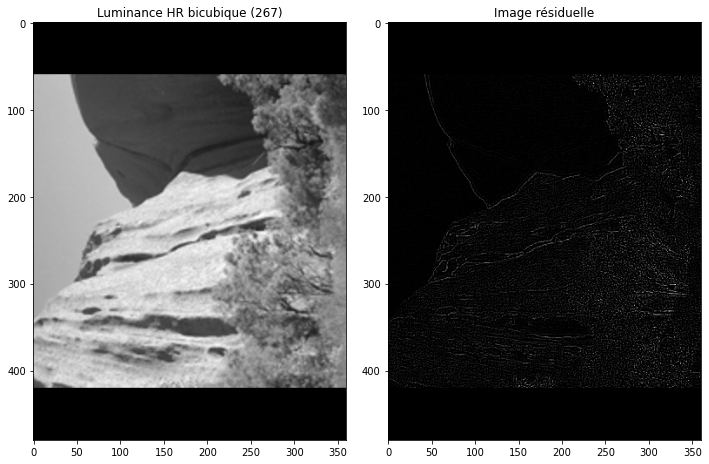

In [68]:
index = random.randrange(0,len(images)+1)

images_augmente = imageDataAugmenter(np.array([images_Y_hr[index], images_residuelles_Y[index]]))

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,10))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(images_augmente[0],cmap="gray")
ax[0].set_title("Luminance HR bicubique (%d)" %index)

ax[1].imshow(np.asarray(images_augmente[1].clip(0,255)*255.0,dtype='uint8'),cmap="gray")
ax[1].set_title("Image résiduelle")


Pour augmenter davantage le nombre des échantillons d'entrainement, les images d'entrées vont maintenant être découpées en petits morceaux de manière aléatoire. Ce procédé est souvent utilisé dans les problèmes de régressions sur les images, offrant la possibilité d'effectuer du traitement en parallèle sur plusieurs réseaux de neurones, chacun s'occupant de traiter des petits morceaux d'images.  
Pour cela, nous allons utiliser la fonction [extract_patches_2d](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.extract_patches_2d.html) disponnible avec Scikit Learn.    

In [15]:
taille_morceau = (41,41)
nbr_morceaux = 64

morceaux = feature_extract.image.extract_patches_2d(images_Y_hr[0], patch_size = taille_morceau,max_patches = nbr_morceaux)

In [13]:
morceaux.shape

(64, 41, 41)

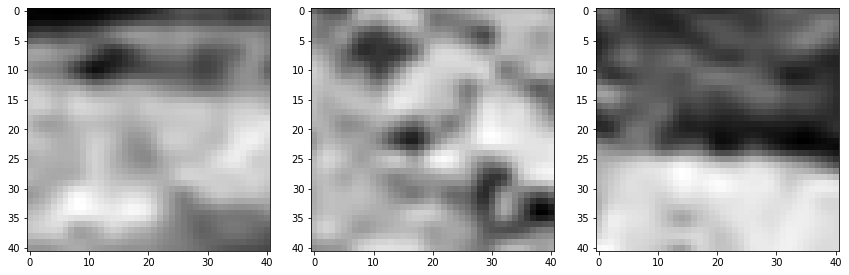

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(12,12))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(morceaux[random.randrange(0,nbr_morceaux+1)],cmap="gray")
ax[1].imshow(morceaux[random.randrange(0,nbr_morceaux+1)],cmap="gray")
ax[2].imshow(morceaux[random.randrange(0,nbr_morceaux+1)],cmap="gray")

# Création des échantillons (X,Y) d'entrainement pour les itérations

Nous allons maintenant créer des paires d'échantillons (X,Y) qui seront utilisés pendant l'entrainement et qui changeront à chaque itération :  

![ReseauNeurone](https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/illustration_1.png?raw=true)  

In [22]:
# Fonction d'extraction aléatoire des morceaux
# Retourne les morceaux X et Y

def ExtractionMorceauxAleatoire(img,nbr,taille):
  morceaux_hr = []
  morceaux_residuelle = []

  for i in range(0,nbr):
    rnd = random.randrange(0,100000)
    morceaux_hr.append(np.array(feature_extract.image.extract_patches_2d(img[0], patch_size = taille, max_patches=1, random_state = rnd)))
    morceaux_residuelle.append(np.array(feature_extract.image.extract_patches_2d(img[1], patch_size = taille, max_patches=1, random_state = rnd)))
  return(np.array([morceaux_hr, morceaux_residuelle])[:,:,0,:,:])

In [23]:
# Création du jeu de données d'entrainement (X,Y)

taille_morceau = (41,41)
nbr_morceaux = 64

X_partitions = []
Y_partitions = []

for i in range(0,len(images)):
  im_aug = imageDataAugmenter(np.array([images_Y_hr[i], images_residuelles_Y[i]]))
  [X,Y] = np.array(ExtractionMorceauxAleatoire(np.array(im_aug),nbr_morceaux,taille_morceau))
  X_partitions.append(X)
  Y_partitions.append(Y)
X_partitions = np.array(X_partitions,dtype="uint8")
Y_partitions = np.array(Y_partitions,dtype='double')


In [99]:
print(X_partitions.shape)
print(X_partitions[0][0])

(916, 64, 41, 41)
[[182 183 182 ... 166 170 169]
 [186 186 184 ... 174 178 179]
 [187 186 184 ... 171 174 177]
 ...
 [ 97  98 100 ... 133 134 135]
 [102 102 101 ... 134 135 135]
 [108 106 104 ... 133 134 133]]


In [81]:
print(Y_partitions.shape)
print(Y_partitions[0][0])

(916, 64, 41, 41)
[[-0.08235294  0.08235294  0.02352941 ...  0.08627451  0.03137255
   0.05098039]
 [ 0.03529412 -0.00392157  0.00784314 ...  0.0627451   0.07450981
   0.05098039]
 [-0.03529412 -0.01568628 -0.00392157 ... -0.03529412  0.01176471
  -0.04705882]
 ...
 [ 0.04705882  0.04705882  0.03921569 ... -0.01960784 -0.04705882
  -0.03529412]
 [ 0.06666667  0.00392157  0.00784314 ... -0.01960784 -0.04705882
  -0.03529412]
 [-0.14509805 -0.08627451 -0.03921569 ... -0.00784314  0.02745098
   0.02352941]]


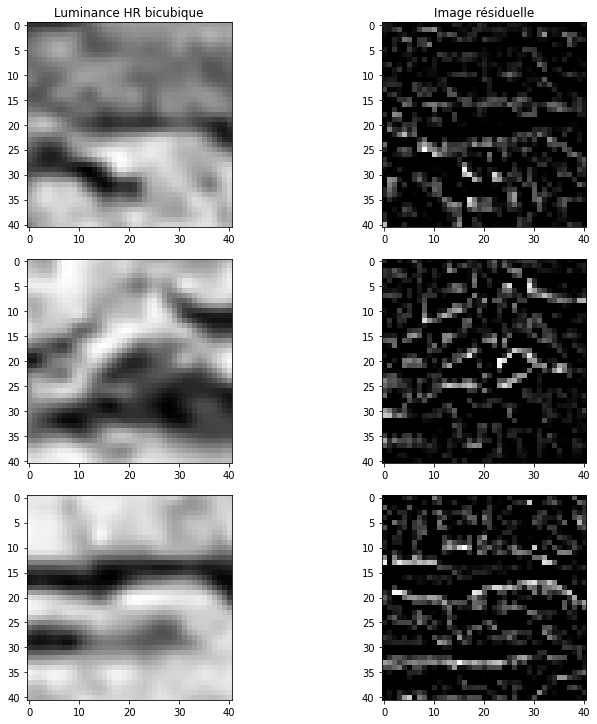

In [100]:
index = random.randrange(0,nbr_morceaux)

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10,10))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(X_partitions[0,index,:,:],cmap="gray")
ax[0].set_title("Luminance HR bicubique")
ax[1].imshow(np.asarray(Y_partitions[0,index,:,:].clip(0,255)*255.0,dtype='uint8'),cmap="gray")
ax[1].set_title("Image résiduelle")

ax[2].imshow(X_partitions[0,index+1,:,:],cmap="gray")
ax[3].imshow(np.asarray(Y_partitions[0,index+1,:,:].clip(0,255)*255.0,dtype='uint8'),cmap="gray")

ax[4].imshow(X_partitions[0,index+2,:,:],cmap="gray")
ax[5].imshow(np.asarray(Y_partitions[0,index+2,:,:].clip(0,255)*255.0,dtype='uint8'),cmap="gray")

# Préparation des données pour Keras 

Le format des données dans les variables X_Partitions et Y_Partitions est : (916,64,41,41) - ce qui représente 916 ensembles de 64 morceaux d'images de 41x41 pixels.  
On va transformer ce format en un nouveau format pour les données d'entrées dans Keras : (916*64,41,41) = (58624,41,41) - ce qui représente 58624 morceaux d'images de 41x41 pixels. Avec un batch_size de 64, chaque ensemble de 64 morceaux sera traité à chaque itération.  

Enfin, on réserve 10% des données pour les tests et on normalise les données en type à virgule flottante sur 64 bits, compris entre 0.0 et 1.0


**1. Reformatage des données au format (916,64,41,41) en un format (58624,41,41)**

In [94]:
X_partitions.shape

(916, 64, 41, 41)

In [95]:
x_entrainement = X_partitions.reshape(916*64,41,41)

In [98]:
print(x_entrainement.shape)
print(x_entrainement[0])

(58624, 41, 41)
[[182 183 182 ... 166 170 169]
 [186 186 184 ... 174 178 179]
 [187 186 184 ... 171 174 177]
 ...
 [ 97  98 100 ... 133 134 135]
 [102 102 101 ... 134 135 135]
 [108 106 104 ... 133 134 133]]


Text(0.5, 1.0, 'x_entrainement[104] (liminance bicubique)')

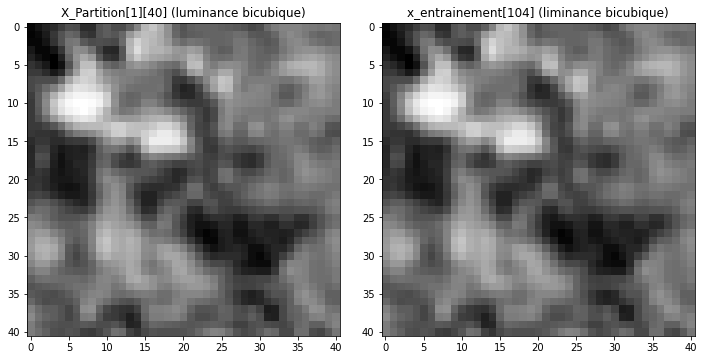

In [107]:
index = random.randrange(0,nbr_morceaux)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,10))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(X_partitions[1][index],cmap="gray")
ax[0].set_title("X_Partition[1][%d] (luminance bicubique)" %index)
ax[1].imshow(x_entrainement[index+64],cmap="gray")
ax[1].set_title("x_entrainement[%d] (liminance bicubique)" %(index+64))


In [24]:
# Modification du format des données et
# séparation les données d'entrainement et de test
 
x_entrainement, x_test, y_entrainement, y_test = train_test_split(X_partitions.reshape(916*64,41,41), Y_partitions.reshape(916*64,41,41), test_size=0.1)

In [25]:
print(x_entrainement.shape)
print(x_entrainement[0])

(52761, 41, 41)
[[62 65 69 ... 28 18 10]
 [66 68 68 ... 25 16  9]
 [67 67 64 ... 38 34 22]
 ...
 [52 55 55 ... 63 62 60]
 [52 55 55 ... 64 60 56]
 [53 54 54 ... 66 60 52]]


In [26]:
print(y_entrainement.shape)
print(y_entrainement[0])

(52761, 41, 41)
[[-0.01176471 -0.02745098  0.00392157 ...  0.01960784 -0.03137255
  -0.00784314]
 [ 0.02352941  0.02745098 -0.01960784 ... -0.07058824 -0.03529412
  -0.00392157]
 [ 0.00392157 -0.01960784  0.01176471 ... -0.01568628  0.01176471
  -0.03921569]
 ...
 [-0.01568628  0.01568628  0.04313726 ...  0.01568628  0.02352941
   0.        ]
 [ 0.00392157 -0.02745098  0.03529412 ... -0.01568628 -0.01960784
  -0.02352941]
 [ 0.05098039 -0.04705882 -0.00392157 ...  0.00784314 -0.00392157
   0.00392157]]


Text(0.5, 1.0, 'y_entrainement[21] (image résiduelle)')

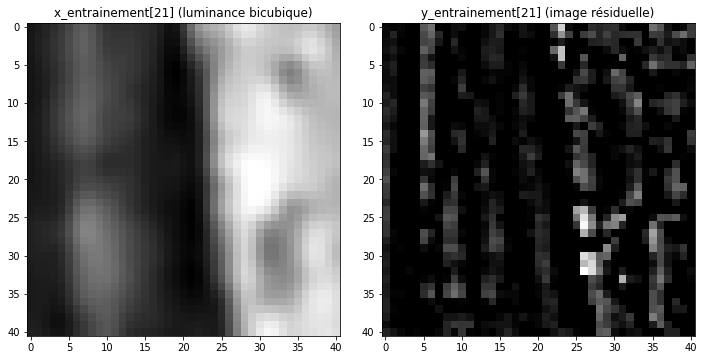

In [27]:
index = random.randrange(0,nbr_morceaux)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,10))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(x_entrainement[index],cmap="gray")
ax[0].set_title("x_entrainement[%d] (luminance bicubique)" %index)
ax[1].imshow(np.array(y_entrainement[index].clip(0,255)*255.0).astype('uint8'),cmap="gray")
ax[1].set_title("y_entrainement[%d] (image résiduelle)" %index)

**2. Structuration des données d'entrée pour Keras au format "channels_first" et normalisation des valeurs**

Les données sont structurées afin d'être compatibles avec la forme d'entrée attendue par Keras :  
- Soit du type : (RGB, hauteur, largeur)
- Soit du type : (hauteur, largeur, RGB)  
  
Ensuite, on normalise les données X en type flottant 64 bits, dont les valeurs sont comprises entre 0.0 et 1.0.

In [28]:
# Choix du format des données
choix = "channels_first"
K.set_image_data_format(choix)

if K.image_data_format() == 'channels_first':
    x_entrainement = x_entrainement.reshape(x_entrainement.shape[0], 1, 41, 41)
    x_test = x_test.reshape(x_test.shape[0], 1, 41, 41)
    y_entrainement = y_entrainement.reshape(y_entrainement.shape[0], 1, 41, 41)
    y_test = y_test.reshape(y_test.shape[0], 1, 41, 41)
    input_shape = (1, 41, 41)
else:
    x_entrainement = x_entrainement.reshape(x_entrainement.shape[0], 41, 41, 1)
    x_test = x_test.reshape(x_test.shape[0], 41, 41, 1)
    y_entrainement = y_entrainement.reshape(y_entrainement.shape[0], 41, 41, 1)
    y_test = y_test.reshape(y_test.shape[0], 41, 41, 1)
    input_shape = (41, 41, 1)

x_entrainement = x_entrainement.astype('double')/255.0
x_test = x_test.astype('double')/255.0

print(x_entrainement.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

52761 train samples
5863 test samples


In [29]:
print(x_entrainement.shape)
print(x_entrainement[0])
print(y_entrainement.shape)
print(y_entrainement[0])

(52761, 1, 41, 41)
[[[0.24313725 0.25490196 0.27058824 ... 0.10980392 0.07058824 0.03921569]
  [0.25882353 0.26666667 0.26666667 ... 0.09803922 0.0627451  0.03529412]
  [0.2627451  0.2627451  0.25098039 ... 0.14901961 0.13333333 0.08627451]
  ...
  [0.20392157 0.21568627 0.21568627 ... 0.24705882 0.24313725 0.23529412]
  [0.20392157 0.21568627 0.21568627 ... 0.25098039 0.23529412 0.21960784]
  [0.20784314 0.21176471 0.21176471 ... 0.25882353 0.23529412 0.20392157]]]
(52761, 1, 41, 41)
[[[-0.01176471 -0.02745098  0.00392157 ...  0.01960784 -0.03137255
   -0.00784314]
  [ 0.02352941  0.02745098 -0.01960784 ... -0.07058824 -0.03529412
   -0.00392157]
  [ 0.00392157 -0.01960784  0.01176471 ... -0.01568628  0.01176471
   -0.03921569]
  ...
  [-0.01568628  0.01568628  0.04313726 ...  0.01568628  0.02352941
    0.        ]
  [ 0.00392157 -0.02745098  0.03529412 ... -0.01568628 -0.01960784
   -0.02352941]
  [ 0.05098039 -0.04705882 -0.00392157 ...  0.00784314 -0.00392157
    0.00392157]]]


# Définition de la structure du réseau VDSR

La structure du réseau de neurones VDSR est la suivante :
- Une couche de **convolution 2D** avec **64 filtres** à convolution de **3x3 pixels**, un **padding de type same** avec un **stride de 1** (ajout d'une colonne à gauche et à droite de l'entrée et d'une ligne en haut et à bas de l'entrée). La sortie a donc la même dimension que l'entrée. Chaque couche de convolution 2D est suivie d'une **fonction d'activation de type ReLU** qui introduit une non-linéarité dans le réseau.  
Les **poids sont initialisés** [**méthode de Kaiming**](https://paperswithcode.com/method/he-initialization). Cette méthode initialise les poids avec des valeurs aléatoires tirées d'une distribution normale à valeur moyenne nulle et à variance égale à 2/(3x3x1) (filtres 3x3 et images en N&B donc 1 canal).  
Les **offsets sont initialisés par défaut à zéros**.
- 18 paires de **couches cachées**. Chaque paire est constituée de :
    - Une couche de **convolution 2D** avec **64 filtres** à convolution de **3x3 pixels**, un **padding de type same** avec un **stride de 1**. Les **poids sont initialisés avec la méthode de Kaiming** et les **offsets sont initialisés par défaut à zéros**.
    - Une **fonction d'activation de type ReLU**.
- Une **couche de convolution 2D** avec **un seul filtre de 3x3 pixels** sans fonction d'activation de sortie. Le but de cette couche de sortie est de reconstruire l'image. Les autres caractéristiques sont identiques aux couches de convolutions précédentes.  


**Régularisation L2** 

>La régularisation L2 ajoute un terme de régularisation aux poids de la fonction de pertes. Les offsets ne sont pas régularisés. Cela permet de réduire le sur-apprentissage.

In [30]:
# Construction du modèle VDSR

l2reg = 0.0001

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu', kernel_initializer="he_normal", input_shape=input_shape,  kernel_regularizer=regularizers.l2(l=l2reg)))

for i in range(0,18):
  model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l=l2reg)))

model.add(Conv2D(1, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l=l2reg)))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 41, 41)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 41, 41)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 41, 41)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 41, 41)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 41, 41)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 41, 41)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 41, 41)        3

# Entrainement du modèle

Ce modèle étant un modèle particulièrement lourd, nous allons optimiser les calculs lors de l'entrainement en jouant sur les paramètres suivants :
- Le type d'algorithme choisi est l'algotithme du gradient stochastique avec moment
- Le taux d'apprentissage va décroitre pendant l'entrainement
- La valeur du gradient d'un paramètre d'apprentissage doit rester dans un intervalle donné

**Type d'algorithme utilisé**  

>Le calcul de l'erreur est basé sur **l'erreur quadratique moyenne**, et l'optimiseur utilisé est de type **SGDM (stochastic gradient descent with momentum - [Algorithme du gradient stochastique avec moment](https://fr.wikipedia.org/wiki/Algorithme_du_gradient_stochastique))**. Contrairement à la méthode de descente du gradient que nous avons étudiée précédemment, cette méthode stochastique calcule les dérivées des fonctions de coût par rapport aux poids et aux offsets à des points choisis aléatoirement. Par conséquent, le nombre de calculs effectués décroit. La valeur du moment est choisie à 0.9.





**Décroissance du taux d'apprentissage pendant l'entrainement**  

>Le **taux d'apprentissage** est réglé initialement sur une valeur de 0.1 et paramétré pour décroitre d'un facteur de 0.1 toutes les 10 périodes. Ce réglage se fait en utilisant l'api [learning rate schedules](https://keras.io/api/optimizers/learning_rate_schedules/) de Keras, en particulier en utilisant une paramétrisation temporelle du taux d'apprentissage ([Inverse Time Decay](https://keras.io/api/optimizers/learning_rate_schedules/inverse_time_decay/)).  
  


**Surveillance des valeurs du gradients** 

>L'entrainement d'un modèle d'apprentissage profond demande beaucoup de temps. On peut augmenter le taux d'apprentissage pour le réduire mais cela peut engendrer une divergence de l'algorithme du gradient et un échec d'apprentissage du réseau. Afin de garder le gradient dans un intervalle significatif, nous utilisons la fonction de coupure du gradient (gradient clipping method). Vous trouverez [sur cette page](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/) différentes méthodes pour éviter les problèmes de divergence de gradient. On fait en sorte que si la norme L2 (racine carré de la somme des composantes au carré) du gradient d'un pramètre d'apprentissage dépasse la valeur 0.01, alors le gradient est mis à l'échelle de sorte que sa norme L2 soit égale à 0.01.  

**Personnalisation de la fonction d'objectif**  
>Nous allons utiliser l'erreur quadratique moyenne divisée par deux (half mean squared error) :  
>
>$erreur = \frac{1}{2}\sum\limits_{p = 1}^{HLC} {{{\left( {{y_p} - {{\hat y}_p}} \right)}^2}}$  
  >
>
>Avec :  
  - ${y_p}$ : Valeur de la sortie attendue sur le pixel $p$
  - ${\hat y_p}$ : Valeur de la sortie estimée par le modèle sur le pixel $p$
  - $H$, $L$, $C$ : Hauteur, largeur et canaux de l'image  



**Personnalisation de la métrique**  
>Pour la métrique, nous allons afficher la racine carrée de l'erreur quadratique moyenne (Root Mean Squared Error - RMSE) ainsi que le pourcentage d'erreur (accurancy).

Le **nombre de périodes** est réglé sur 100. Puisque nous avons réservé 90% des ensembles de morceaux pour l'entrainement, il y aura donc 0.9*916 = environ 825 ensembles de 64 morceaux calculés à chaque période. Comme la valeur du batch_size est de 64, à chaque itération l'algorithme traite 64 morceaux. Il y aura donc 825 itérations par période. 



In [31]:
import scipy.io
from google.colab import files

scipy.io.savemat('x_entrainement.mat',{'x_entrainement':x_entrainement[0:64]})
scipy.io.savemat('y_entrainement.mat',{'y_entrainement':y_entrainement[0:64]})

files.download('x_entrainement.mat')
files.download('y_entrainement.mat')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
periodes = 100
batch_size = 64

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = schedules.InverseTimeDecay(
    initial_learning_rate=0.1,
    decay_steps=10,
    decay_rate=0.1)

# Définition de la fonction d'objectif
# format y_predit  : (64,1,41,41)
# format y_attendu : (64,1,41,41)
def keras_half_mean_squared_function(y_attendu, y_predit):
  erreur = K.sum(K.square(y_attendu[:,0,:,:] - y_predit[:,0,:,:]))
  return(0.5*erreur/batch_size)

#definition de la métrique
def keras_mean_squared_metric(y_attendu, y_predit):
  erreur = K.sqrt(K.mean(K.square(y_attendu[:,0,:,:] - y_predit[:,0,:,:])))
  return(erreur)

model.compile(loss=keras_half_mean_squared_function, optimizer=SGD(learning_rate=lr_schedule, momentum=0.9, clipnorm=0.01), metrics=[keras_mean_squared_metric, 'acc'])

historique = model.fit(x_entrainement, y_entrainement, batch_size=batch_size, epochs=periodes, verbose=1, validation_data=(x_test, y_test))

Affichons les informations sur la précision du modèle après entrainement :

In [ ]:
# Evalue la précision du modèle avec les données de tests
score = model.evaluate(x_test, y_test, verbose=0)
print('Pertes (Test) :', score[0])
print('Précision (Test) :', score[1])

Pertes (Test) : 79.69791412353516
Précision (Test) : 0.019290557131171227


# Sauvegarde du modèle

In [ ]:
model_structure = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_structure)
model.save_weights("weights.h5")

In [ ]:
from google.colab import files
files.download('model.json')
files.download('weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Chargement du modèle entrainé sous Google Colab

In [ ]:
!wget --no-check-certificate --content-disposition "https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/Donn%C3%A9es/VDSR_model.json"
!wget --no-check-certificate --content-disposition "https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Donn%C3%A9es/VDSR_weights.h5?raw=true"

In [ ]:
periodes = 100
batch_size = 64

lr_schedule = schedules.InverseTimeDecay(
    initial_learning_rate=0.1,
    decay_steps=10,
    decay_rate=0.1)

def keras_half_mean_squared_function(y_attendu, y_predit):
  HMSE = 0.0
#  for i in range(0,63):
#    for j in range(0,40):
#        HMSE = HMSE + K.sum(K.square(y_attendu[i,0,j,0:40] - y_predit[i,0,j,0:40]))
  HMSE = HMSE + K.sum(K.square(y_attendu[0:63,0,0:40,0:40] - y_predit[0:63,0,0:40,0:40]))
  return(0.5*HMSE)

with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
rmodel = model_from_json(loaded_model_json)
rmodel.load_weights("weights.h5")

rmodel.compile(loss=keras_half_mean_squared_function, optimizer=SGD(learning_rate=lr_schedule, momentum=0.9, clipnorm=0.01), metrics='acc')
rmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 41, 41)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 41, 41)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 41, 41)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 41, 41)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 41, 41)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 41, 41)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 41, 41)        3

In [ ]:
x_test.shape

(5863, 1, 41, 41)

In [ ]:
batch_size = 64

score = rmodel.evaluate(x=x_test, y=y_test, batch_size=batch_size, verbose=1)
print('Pertes (Test) :', score[0])
print('Précision (Test) :', score[1])

92/92 [==============================] - 2s 18ms/step - loss: 52.0215 - acc: 0.1359
Pertes (Test) : 52.37358856201172
Précision (Test) : 0.13503867387771606


# Prédictions avec le modèle de Google Colab

Effectuons quelques prédictions sur les images de tests afin d'observer les différences obtenues entre ce qui est attendu et ce qui est estimé.

In [ ]:
x_test.shape

(5863, 1, 41, 41)

Text(0.5, 1.0, 'Prédiction (image résiduelle)')

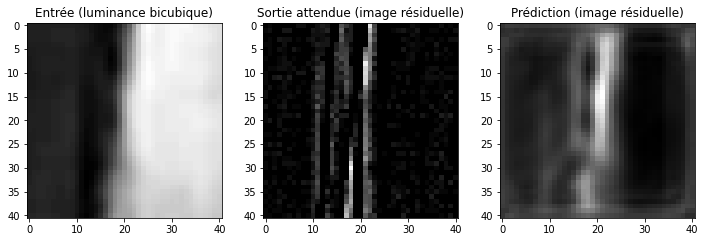

In [ ]:
index = random.randrange(0,len(x_test))

y_prediction = rmodel.predict(x_test[index].reshape(1,1,41,41))[0,0,:,:]

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(10,10))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(x_test[index][0,:,:],cmap="gray")
ax[0].set_title("Entrée (luminance bicubique)")
ax[1].imshow(y_test[index][0,:,:],cmap="gray")
ax[1].set_title("Sortie attendue (image résiduelle)")
ax[2].imshow(y_prediction,cmap="gray")
ax[2].set_title("Prédiction (image résiduelle)")


array([[[0.26666667, 0.27058824, 0.27058824, ..., 0.93333333,
         0.9254902 , 0.93333333],
        [0.26666667, 0.27058824, 0.27058824, ..., 0.9254902 ,
         0.92156863, 0.9254902 ],
        [0.26666667, 0.27058824, 0.27058824, ..., 0.92941176,
         0.91764706, 0.92156863],
        ...,
        [0.28627451, 0.25098039, 0.22352941, ..., 0.94509804,
         0.94117647, 0.94509804],
        [0.27843137, 0.24313725, 0.21960784, ..., 0.94509804,
         0.94117647, 0.94509804],
        [0.27058824, 0.23529412, 0.21176471, ..., 0.94509804,
         0.94117647, 0.94509804]]])

# Chargement du modèle complet et analyse de la précision du modèle

Le modèle a été entrainé sur Matlab et exporté au format [ONNX](https://onnx.ai/) (Open Neural Network Exchange).  
Ce [fichier](https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/modeles/VDSR_export.onnx?raw=true) peut être lu par exemple avec l'application [Netron](https://github.com/lutzroeder/Netron) afin d'en visualiser la structure et les différents paramètres.

In [54]:
!wget --no-check-certificate --content-disposition "https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/modeles/VDSR_export.onnx?raw=true"

--2021-02-22 14:57:02--  https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/modeles/VDSR_export.onnx?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/modeles/VDSR_export.onnx [following]
--2021-02-22 14:57:02--  https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/modeles/VDSR_export.onnx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/modeles/VDSR_export.onnx [following]
--2021-02-22 14:57:02--  https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/modeles/VDSR_export.onnx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.

Pour importer notre modèle dans Keras, nous allons utiliser la librairie [onnx2keras](https://github.com/nerox8664/onnx2keras).

In [55]:
!pip install onnx onnx2keras --quiet

     |████████████████████████████████| 14.5MB 203kB/s 


In [ ]:
import onnx
from onnx2keras import onnx_to_keras

# Chargement du modèle ONNX
onnx_model = onnx.load('VDSR_export.onnx')

# Conversion du modèle (input : nom de l'entrée du modèle entrainé)
k_model = onnx_to_keras(onnx_model, ['InputLayer'])

In [ ]:
k_model.summary()

In [59]:
lr_schedule = schedules.InverseTimeDecay(
    initial_learning_rate=0.1,
    decay_steps=10,
    decay_rate=0.1)

def keras_half_mean_squared_function(y_attendu, y_predit):
  erreur = K.sum(K.square(y_attendu[:,0,:,:] - y_predit[:,0,:,:]))
  return(0.5*erreur/batch_size)

def keras_mean_squared_metric(y_attendu, y_predit):
  erreur = K.sqrt(K.mean(K.square(y_attendu[:,0,:,:] - y_predit[:,0,:,:])))
  return(erreur)

k_model.compile(loss=keras_half_mean_squared_function, optimizer=SGD(learning_rate=lr_schedule, momentum=0.9, clipnorm=0.01), metrics=[keras_mean_squared_metric, 'acc'])

In [60]:
x_test.shape

(5863, 1, 41, 41)

In [61]:
batch_size = 64

score = k_model.evaluate(x=x_test, y=y_test, batch_size=batch_size, verbose=1)
print('Pertes (Test) :', score[0])
print('Précision (Test) :', score[1])

92/92 [==============================] - 4s 42ms/step - loss: 2.0709 - keras_mean_squared_metric: 0.0495 - acc: 0.0933
Pertes (Test) : 2.00307297706604
Précision (Test) : 0.048704832792282104


# Prédictions avec le modèle complet

In [66]:
y_prediction = k_model.predict(x_test[index].reshape(1,1,41,41))

In [68]:
y_prediction.shape

(1, 1, 41, 41)

Text(0.5, 1.0, 'Prédiction (image résiduelle)')

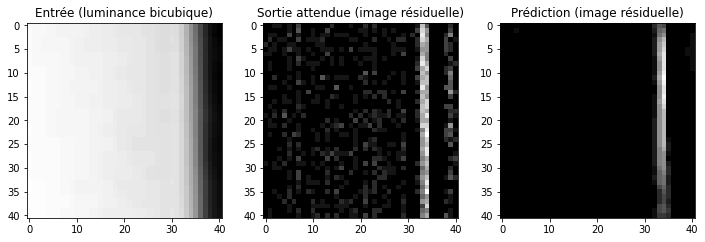

In [78]:
index = random.randrange(0,len(x_test))

y_prediction = k_model.predict(x_test[index].reshape(1,1,41,41))[0,0,:,:]

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(10,10))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow((x_test[index][0,:,:]*255.0).astype('uint8'),cmap="gray")
ax[0].set_title("Entrée (luminance bicubique)")

ax[1].imshow(np.array(y_test[index][0,:,:].clip(0,255.0)*255.0).astype('uint8'),cmap="gray")
ax[1].set_title("Sortie attendue (image résiduelle)")

ax[2].imshow(np.array(y_prediction.clip(0,255.0)*255.0).astype('uint8'),cmap="gray")
ax[2].set_title("Prédiction (image résiduelle)")

# Prédiction d'une image entière 

**1. Découpage de l'image en morceaux**

Pour réaliser la prédiction sur une image entière, il faut tout d'abord la découper en morceaux de taille équivalente aux dimensions des images utilisées pour l'entrainement du modèle (41x41 pixels). Ensuite, il faut agencer ces morceaux les uns à la suite des autres dans un vecteur dont le format est compatible avec celui du modèle d'entrée (none, 1, 41, 41).  

Voici l'exemple à suivre pour transformer une image de (360x480) en 20 morceaux de (100x100) :  

![ReseauNeurone](https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/decoupage_images.png?raw=true) 

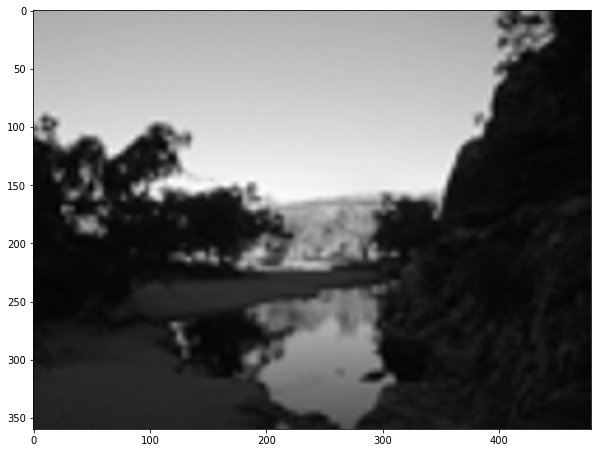

In [79]:
image = images_Y_hr[3]
plt.figure(figsize=(10,10))
plt.imshow(image,cmap="gray")

Affichons le format de cette image :

In [80]:
np.array(image).shape

(360, 480)

Transformons cette image au format (1, hauteur, laregeur, 1) qui est demandé par la fonction de tensorflow [extract_patches](https://www.tensorflow.org/api_docs/python/tf/image/extract_patches) permettant de découper les tenseurs puis réalisons le découpage de l'image :

In [81]:
np.array([[image]]).reshape(1,image.shape[0],image.shape[1],1).shape

(1, 360, 480, 1)

In [83]:
taille_morceaux = [1,100,100,1]
morceaux = extract_patches(np.array([[image]]).reshape(1,image.shape[0],image.shape[1],1), sizes = taille_morceaux, strides=taille_morceaux, rates = [1,1,1,1], padding='SAME')

La variable retournée est de la forme (1,A,B,C) avec :
- A : Nombre de paquets "verticaux" au format découpés 
- B : Nombre de paquets "horizontaux" au format découpé 

In [84]:
morceaux.shape

TensorShape([1, 4, 5, 10000])

On transforme maintenant le format afin d'avoir les morceaux agencé dans le tenseur :

In [85]:
n_X = morceaux[0].shape[1]
n_Y = morceaux[0].shape[0]

morceaux = np.reshape(morceaux[0],(morceaux[0].shape[0]*morceaux[0].shape[1],taille_morceaux[1],taille_morceaux[2]))

In [88]:
print(morceaux.shape)
print(morceaux[0,:,:])

(20, 100, 100)
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 194 194 194]
 [  0   0   0 ... 194 194 194]
 [  0   0   0 ... 194 195 195]]


Reconstituons l'image à l'aide des morceaux :

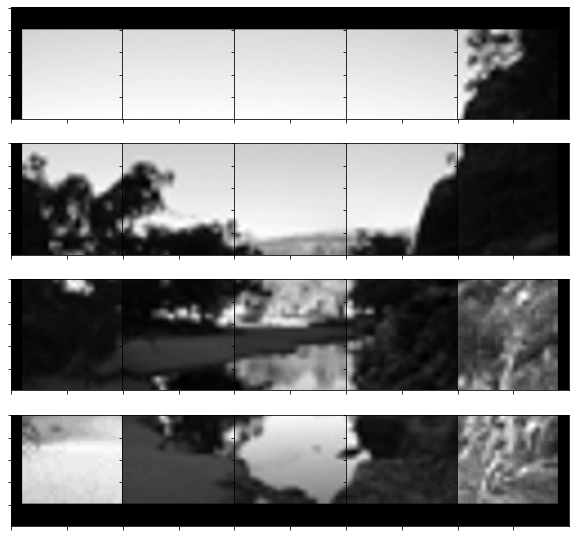

In [90]:
fig = plt.figure(figsize=(10,10))
ax = [fig.add_subplot(n_Y,n_X,i+1) for i in range(n_X*n_Y)]

k=0
for a in ax:
    a.imshow(morceaux[k,:,:],cmap="gray")
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_aspect('equal')
    k=k+1
fig.subplots_adjust(wspace=0, hspace=0)

**2. Prédiction de l'image**

On commence par découper l'image au format (41x41) puis adapter le tenseur d'entrée au format (None,1,41,41)

In [92]:
# Charge l'image dans la variable image
image = images_Y_hr[3]
sortie_attendue =  images_residuelles_Y[3]

hauteur_image = image.shape[0]
largeur_image = image.shape[1]

# Découpe l'image en morceaux de (41x41) pixels
taille_morceaux = [1,41,41,1]
morceaux = extract_patches(np.array([[image]]).reshape(1,image.shape[0],image.shape[1],1), sizes = taille_morceaux, strides=taille_morceaux, rates = [1,1,1,1], padding='SAME')

# Sauvegardes le nombres de morceaux verticaux et horizontaux
n_Y = morceaux[0].shape[0]
n_X = morceaux[0].shape[1]

# Modifie le format des morceaux au format (nombre_morceaux,41,41)
morceaux = np.reshape(morceaux[0],(morceaux[0].shape[0]*morceaux[0].shape[1],1,taille_morceaux[1],taille_morceaux[2]))

In [93]:
morceaux.shape

(108, 1, 41, 41)

In [94]:
morceaux[0,0,:,:]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 175, 175, 175],
       [  0,   0,   0, ..., 175, 175, 175],
       [  0,   0,   0, ..., 176, 176, 176]], dtype=uint8)

On lance le modèle puis on récupère les morceaux :

In [95]:
prediction = k_model.predict(morceaux.astype('double')/255.0)
prediction = (prediction.clip(0,255)*255.0).astype("uint8")
prediction.shape

(108, 1, 41, 41)

In [96]:
prediction[0,0,:,:]

array([[ 0,  0,  0, ...,  3,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 3,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0, 12, ...,  0,  0,  0],
       [ 0,  0, 12, ...,  0,  0,  0]], dtype=uint8)

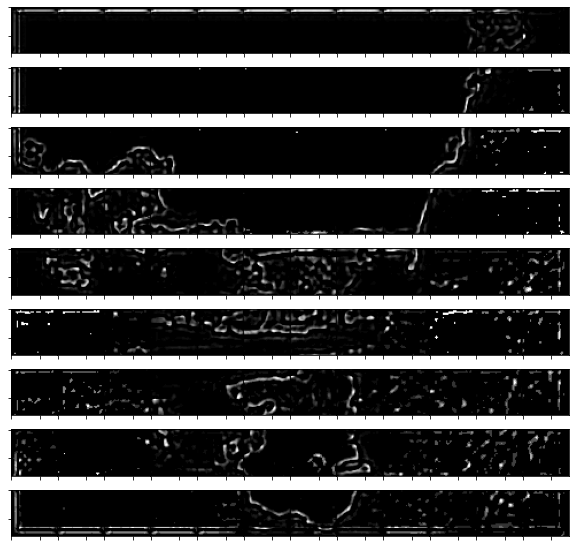

In [97]:
fig = plt.figure(figsize=(10,10))
ax = [fig.add_subplot(n_Y,n_X,i+1) for i in range(n_X*n_Y)]

k=0
for a in ax:
    a.imshow(prediction[k,0,:,:],cmap="gray")
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_aspect('equal')
    k=k+1
fig.subplots_adjust(wspace=0, hspace=0)

On assemble les morceaux pour recréer l'image :

In [98]:
prediction.shape

(108, 1, 41, 41)

In [99]:
def ReassemblageImage(img, n_X, n_Y):
  reconstruction = np.zeros([n_Y*41,n_X*41],dtype=np.uint8)
  k=0

  for i in range(0,n_Y):
    for j in range(0,n_X):
      reconstruction[i*41:i*41+41,j*41:j*41+41]=img[k,:,:]
      k = k+1
  return(reconstruction)

Text(0.5, 1.0, 'Sortie attendue')

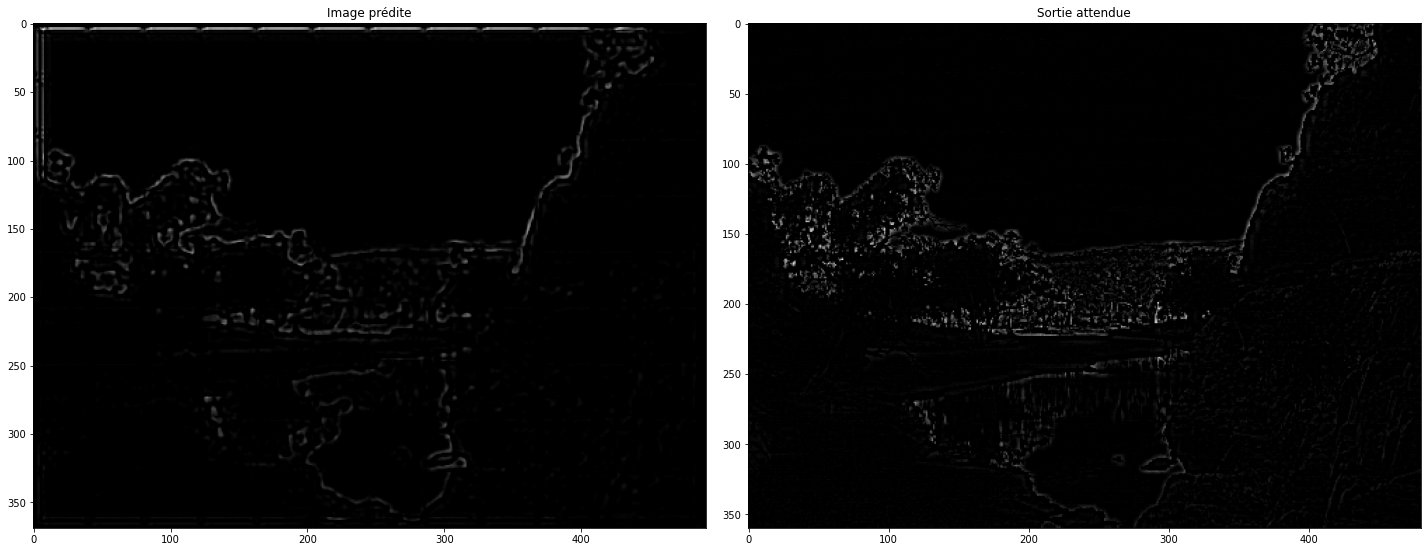

In [101]:
rec = ReassemblageImage(prediction,n_X,n_Y)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,20))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(np.array(rec),cmap="gray")
ax[0].set_title("Image prédite")

ax[1].imshow(np.array(sortie_attendue.clip(0,255.0)*255.0,dtype='uint8'),cmap="gray")
ax[1].set_title("Sortie attendue")


Text(0.5, 1.0, 'Prédiction (image résiduelle)')

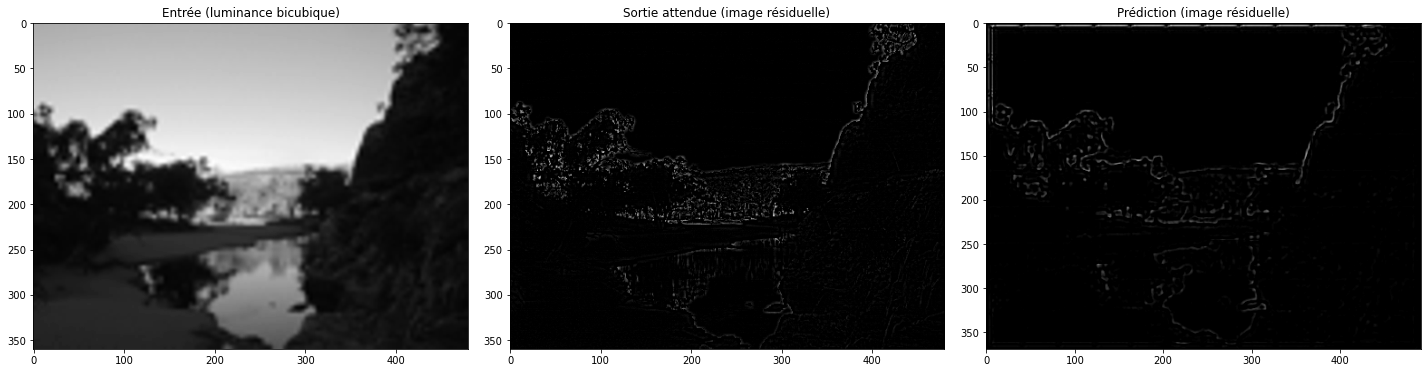

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20,20))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(image,cmap="gray")
ax[0].set_title("Entrée (luminance bicubique)")
ax[1].imshow(np.array((sortie_attendue).clip(0,255.0)*255.0,dtype='uint8'),cmap="gray")
ax[1].set_title("Sortie attendue (image résiduelle)")
ax[2].imshow(rec,cmap="gray")
ax[2].set_title("Prédiction (image résiduelle)")